In [13]:
import pymongo
import json
from pymongo import MongoClient, InsertOne
import os
import glob
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
import pprint
plt.style.use([hep.style.ROOT, hep.style.firamath])
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [14]:
client = pymongo.MongoClient("mongodb://127.0.0.1:27017") # Connect to local database

In [15]:
idir = "/Users/marko/brown-plots/hgcal-econd/hgcal-mongodb/data/ECOND/"
fnames_econd = list(np.sort(glob.glob(f"{idir}/report*.json")))

In [16]:
mydatabase = client['DemoDB']
mycol_econd = mydatabase['ECOND']

In [17]:
mydatabase = client['DemoDB']
mycol_econt = mydatabase['ECONT']

In [18]:
idir = "/Users/marko/brown-plots/hgcal-econd/hgcal-mongodb/data/ECONT/" ## Can insert your own local directory
fnames_econt = list(np.sort(glob.glob(f"{idir}/report*.json")))

In [7]:
#mydatabase = client['jsonDB'] # create new database
#mycol = mydatabase['hexa44'] # dict of type {'unique_id' : json_full_report}

In [19]:
def jsonFileUploader(fname, mycol):
    ## open the JSON File
    with open(fname) as jsonfile:
        data = json.load(jsonfile)
    ## Insert File into the DB 
    x = mycol.insert_one(data) # Write in DB

In [20]:
## Load all the JSON files in the database
for i, (fname) in enumerate(fnames_econt):
    try:
        jsonFileUploader(fname,mycol_econt)
    except Exception as e:
        print(e, fname, i)

MongoDB can only handle up to 8-byte ints /Users/marko/brown-plots/hgcal-econd/hgcal-mongodb/data/ECONT/report_ECONT_chip_149_2024-03-14_12-03-41.json 22
Expecting ',' delimiter: line 119088 column 23 (char 2510792) /Users/marko/brown-plots/hgcal-econd/hgcal-mongodb/data/ECONT/report_ECONT_chip_243_2024-03-13_12-25-36.json 76


In [21]:
## Load all the JSON files in the database
for i, (fname) in enumerate(fnames_econd):
    try:
        jsonFileUploader(fname,mycol_econd)
    except Exception as e:
        print(e, fname, i)

In [22]:
## Load the data in a way that makes it compatible with my legacy code
ECONT = [data for data in mydatabase['ECONT'].find()]
print(len(ECONT))

143


In [23]:
## This creates an xlsx file that summarizes the failed chips
## you can run this for yourself and see what the output looks like
## Chip num - chip number
## dataInd - which index in the ECONT list that corresponds to that chip
## testInd - which test number that corresponds to ECONT[i]['tests'][testInd]
## failure mode - indicates how the test crash or failed and the error message
## codeLine - which line in the code that caused the failure
## testName - name of the test that failed
## failureCause - prints the crash message
headers = ["chipNum", "dataInd", "testInd", "failureMode", "codeLine", "testName",  "failureCause"]
workbook = openpyxl.Workbook()
worksheet = workbook.active
worksheet.append(headers)
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'failed' in ECONT[i]['tests'][j]['outcome']:
            chipNum = (ECONT[i]['chip_number'])
            dataIndex = i
            testInd = j
            testName = ECONT[i]['tests'][j]['nodeid']
            if ECONT[i]['tests'][j]['call']['traceback'][0]['message'] != '':
                failureMode = ECONT[i]['tests'][j]['call']['traceback'][0]['message']
            else:
                failureMode = ECONT[i]['tests'][j]['call']['crash']['message']
            failureCause = ECONT[i]['tests'][j]['call']['crash']['message']
            codeLine = ECONT[i]['tests'][j]["call"]["crash"]["lineno"]
            X = [chipNum, dataIndex, testInd, failureMode, codeLine, testName, failureCause]
            X = [str(x) if isinstance(x, np.generic) else x for x in X]
            worksheet.append(X)
workbook.save('/Users/marko/brown-plots/hgcal-econd/hgcal-mongodb/results/Failed_chip_retested.xlsx')

In [24]:
odir = '/Users/marko/brown-plots/hgcal-econd/hgcal-mongodb/results/plots'

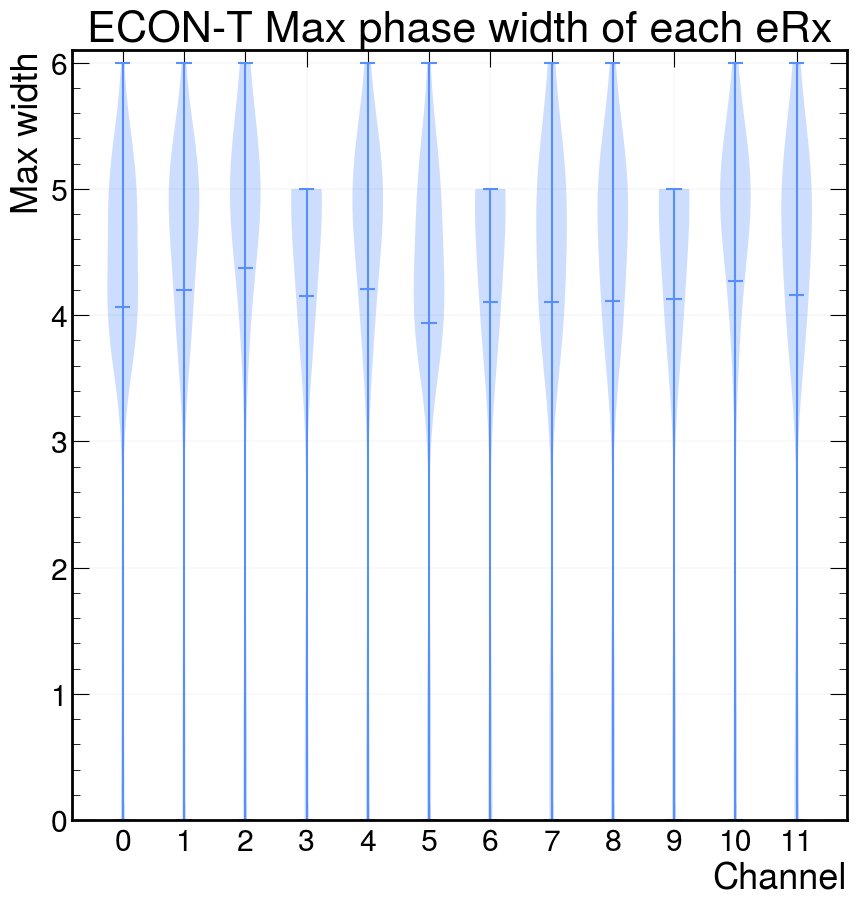

In [25]:
max_width = []
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'metadata' in ECONT[i]['tests'][j].keys():
            if 'test_io.py::test_ePortRXPRBS' in ECONT[i]['tests'][j]['nodeid']:
                max_width.append(ECONT[i]['tests'][j]['metadata']['maxwidth'])
data = np.array(max_width)
plt.violinplot(data, showmeans=True, showextrema=True)
plt.xticks(range(1,13), ['0','1', '2', '3' ,'4', '5', '6',
                              '7', '8', '9', '10', '11'])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.title(f"ECON-T Max phase width of each eRx")
plt.grid(color='black', linestyle='--', linewidth=0.05)
plt.ylim(0,6.1)
plt.ylabel(f'Max width')
plt.xlabel('Channel')
plt.savefig(f'{odir}/Max_width_volin_of_all_eRx_Econt.png', dpi=300, facecolor = "w")
plt.show()

In [27]:
#for i in range(len(ECONT)):
#    for j in range(len(ECONT[i]['tests'])):
#        if 'metadata' in ECONT[i]['tests'][j].keys():
#            if 'test_io.py::test_ePortRXPRBS' in ECONT[i]['tests'][j]['nodeid']:
#                max_width.append(ECONT[i]['tests'][j]['metadata']['maxwidth'])
#ECONT_ePortRXPRBS = mydatabase['ECONT'].find({"tests":{"$elemMatch":{"outcome":"failed", "nodeid":"test_io.py::test_ePortRXPRBS"}}})
ECONT_ePortRXPRBS = [data for data in mydatabase['ECONT'].find({"tests":{"$elemMatch":{"nodeid":"test_io.py::test_ePortRXPRBS"}}})]

In [40]:
max_width = []
for report in ECONT_ePortRXPRBS:
    max_width.append(list(filter(lambda test: test['nodeid'] == "test_io.py::test_ePortRXPRBS",report['tests']))[0]['metadata']['maxwidth'])

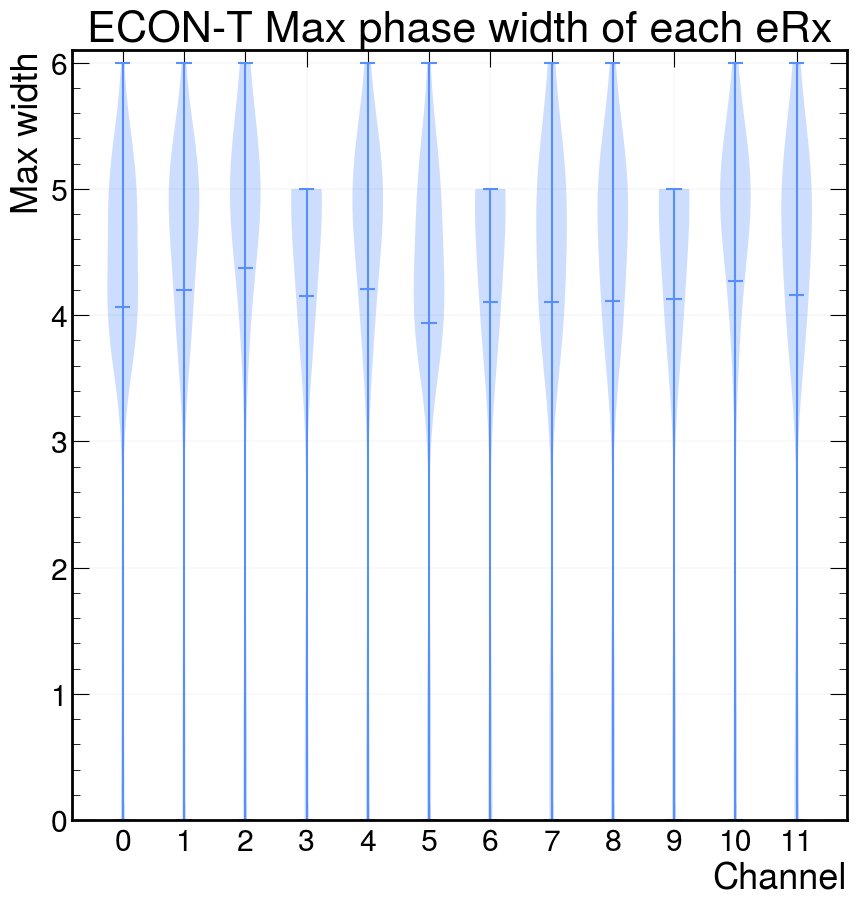

In [41]:
data = np.array(max_width)
plt.violinplot(data, showmeans=True, showextrema=True)
plt.xticks(range(1,13), ['0','1', '2', '3' ,'4', '5', '6',
                              '7', '8', '9', '10', '11'])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.title(f"ECON-T Max phase width of each eRx")
plt.grid(color='black', linestyle='--', linewidth=0.05)
plt.ylim(0,6.1)
plt.ylabel(f'Max width')
plt.xlabel('Channel')
plt.savefig(f'{odir}/Max_width_volin_of_all_eRx_Econt.png', dpi=300, facecolor = "w")
plt.show()

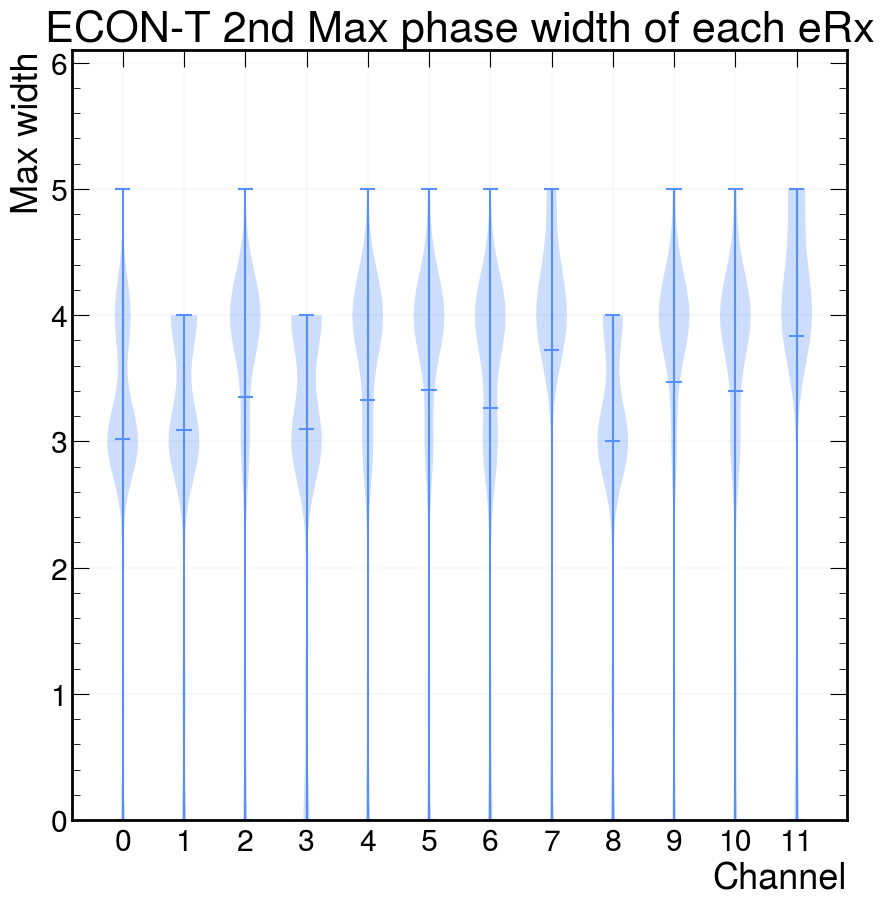

In [12]:
second_max_width = []
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'metadata' in ECONT[i]['tests'][j].keys():
            if 'test_io.py::test_ePortRXPRBS' in ECONT[i]['tests'][j]['nodeid']:
                second_max_width.append(ECONT[i]['tests'][j]['metadata']['second_max_width'])
data = np.array(second_max_width)
plt.violinplot(data, showmeans=True, showextrema=True)
plt.xticks(range(1,13), ['0','1', '2', '3' ,'4', '5', '6',
                              '7', '8', '9', '10', '11'])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.title(f"ECON-T 2nd Max phase width of each eRx")
plt.grid(color='black', linestyle='--', linewidth=0.05)
plt.ylim(0,6.1)
plt.ylabel(f'Max width')
plt.xlabel('Channel')
plt.savefig(f'{odir}/second_Max_width_volin_of_all_eRx_Econt.png', dpi=300, facecolor = "w")
plt.show()

In [ ]:
max_width = []
second_max_width = []
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'metadata' in ECONT[i]['tests'][j].keys():
            if 'test_io.py::test_ePortRXPRBS' in ECONT[i]['tests'][j]['nodeid']:
                second_max_width.append(ECONT[i]['tests'][j]['metadata']['second_max_width'])
                max_width.append(ECONT[i]['tests'][j]['metadata']['maxwidth'])
                
max_width = np.array(max_width).flatten()
second_max_width = np.array(second_max_width).flatten()
plt.hist(max_width, bins= np.arange(0,9,1)-0.5,color='r',alpha=0.5,label=f"Max width \u03BC:{np.mean(max_width):.3f} \u03C3:{np.std(max_width):.3f}")
plt.hist(second_max_width, histtype="step", bins= np.arange(0,9,1)-0.5,color='b',label=f"2Max width \u03BC:{np.mean(second_max_width):.3f} \u03C3:{np.std(second_max_width):.3f}")
plt.title(f"ECON-T eRx width")
plt.axvline(x=2, color='b', label="2Max thresold = 2", linestyle='--')
plt.axvline(x=3, color='r', alpha=0.5, label="Max thresold = 3", linestyle='--')
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.legend(loc="best",fontsize='15')

plt.ylabel('Number of eRx')
plt.xlabel('Phase width')

plt.savefig(f'{odir}/Phase_width__of_all_eRx_Econt.png', dpi=300, facecolor = "w")
plt.show()

In [ ]:
max_width = []
second_max_width = []
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'metadata' in ECONT[i]['tests'][j].keys():
            if 'test_io.py::test_eTX_delayscan' in ECONT[i]['tests'][j]['nodeid']:
                second_max_width.append(ECONT[i]['tests'][j]['metadata']['second_max_width'])
                max_width.append(ECONT[i]['tests'][j]['metadata']['max_width'])
print(len(ECONT),len(max_width))
max_width = np.array(max_width).flatten()
second_max_width = np.array(second_max_width).flatten()
plt.hist(max_width, bins= np.arange(0,73,1)-0.5,color='r',alpha=0.5,label=f"Max width \u03BC:{np.mean(max_width):.3f} \u03C3:{np.std(max_width):.3f}")
plt.hist(second_max_width, histtype="step", bins= np.arange(0,36,1)-0.5,color='b',label=f"2Max width \u03BC:{np.mean(second_max_width):.3f} \u03C3:{np.std(second_max_width):.3f}")
plt.title(f"ECON-T eTx width")
plt.axvline(x=10, color='b', label="2Max thresold = 10", linestyle='--')
plt.axvline(x=11, color='r', alpha=0.5, label="Max thresold = 11", linestyle='--')
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.legend(loc='best', fontsize=15)
plt.ylabel('Number of eTx')
plt.xlabel('Phase width')

plt.savefig(f'{odir}/Phase_width_of_all_eTx_Econt.png', dpi=300, facecolor = "w")

In [ ]:
max_width = []
second_max_width = []
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'metadata' in ECONT[i]['tests'][j].keys():
            if 'test_io.py::test_eTX_delayscan' in ECONT[i]['tests'][j]['nodeid']:
                second_max_width.append(ECONT[i]['tests'][j]['metadata']['second_max_width'])
                max_width.append(ECONT[i]['tests'][j]['metadata']['max_width'])

plt.violinplot(np.array(max_width), showmeans=True, showextrema=True)
plt.xticks(range(1,14), ['0','1', '2', '3' ,'4', '5', '6',
                              '7', '8', '9', '10', '11', '12'])
plt.title(f"ECON-T Max phase width of each eTx")
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
# plt.ylim(11.9,19.1)
plt.ylabel(f'Max width')
plt.xlabel('Channel')
plt.savefig(f'{odir}/Max_width_volin_of_all_eTx_Econt.png', dpi=300, facecolor = "w")
plt.show()

In [ ]:
max_width = []
second_max_width = []
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'metadata' in ECONT[i]['tests'][j].keys():
            if 'test_io.py::test_eTX_delayscan' in ECONT[i]['tests'][j]['nodeid']:
                second_max_width.append(ECONT[i]['tests'][j]['metadata']['second_max_width'])
                max_width.append(ECONT[i]['tests'][j]['metadata']['max_width'])

plt.violinplot(np.array(second_max_width), showmeans=True, showextrema=True)
plt.xticks(range(1,14), ['0','1', '2', '3' ,'4', '5', '6',
                              '7', '8', '9', '10', '11', '12'])
plt.title(f"ECON-T 2Max phase width of each eTx")
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
# plt.ylim(11.9,19.1)
plt.ylabel(f'Second Max width')
plt.xlabel('Channel')
plt.savefig(f'{odir}/2Max_width_volin_of_all_eTx_Econt.png', dpi=300, facecolor = "w")
plt.show()

In [ ]:
pll_width =[]
for i in range(len(ECONT)):
    for j in range(len(ECONT[i]['tests'])):
        if 'metadata' in ECONT[i]['tests'][j].keys():
            if 'test_pll.py::test_pll_capbank_width' in ECONT[i]['tests'][j]['nodeid']:
                pll_width.append(ECONT[i]['tests'][j]['metadata']['pll_capbank_width'])
plt.hist(pll_width,bins = np.arange(12,20,1)-0.5,label=f"PLL width \u03BC:{np.mean(pll_width):.3f} \u03C3:{np.std(pll_width):.3f}")
plt.xlabel("PLL capbank width")
plt.ylabel("Number of chips")

plt.axvline(x=14, color='b', label="Pll capbank thresold = 14", linestyle='--')
plt.legend(loc='best', fontsize=15)
plt.grid(color='black', linestyle='--', linewidth=.05)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.savefig(f'{odir}/pll_width_Econt.png', dpi=300, facecolor = "w")

In [ ]:
ECOND = [data for data in mydatabase['ECOND'].find()]
print(len(ECOND))
data = ECOND[0]

In [ ]:
def plot_eRx_phaseScan(_fileName=None,dataArray=None,outputFileName=None,title='eRx Phase Scan'):
    if dataArray is None:
        data=np.load(_fileName)
    else:
        data=dataArray

    fig,ax=plt.subplots()

    a,b=np.meshgrid(np.arange(12),np.arange(15))

    h=plt.hist2d(a.flatten(),
                 b.flatten(),
                 weights=data.flatten(),
                 bins=(np.arange(13)-.5,
                       np.arange(16)-.5),
                 cmap='RdYlBu_r',
                 alpha=data>0,
                 figure=fig);
    cb=fig.colorbar(h[3])
    cb.set_label(label='Data transmission errors in PRBS',size=32)
    cb.ax.set_yscale('linear')

    plt.ylabel('Phase Select Setting', size=32)
    plt.xlabel('Channel Number', size=32)
    plt.xticks(np.arange(12))
    plt.yticks(np.arange(15))
    plt.title(title)
    if outputFileName is not None:
        plt.savefig(outputFileName,dpi=300, facecolor = "w")

    plt.close(fig)

    return fig

In [ ]:
for i in range(len(data['tests'])):
    if 'metadata' in data['tests'][i].keys(): 
        if 'eTX_errcounts' in data['tests'][i]['metadata'].keys():
            print(i)


In [ ]:
eRx_errcounts = np.array(data['tests'][37]['metadata']['eRX_errcounts'])
plot_eRx_phaseScan(dataArray=eRx_errcounts, outputFileName=f"{odir}/examplePhaseScan")

In [ ]:
def delay_scan_plots(fname = None,
                     dataArray = None,
                     title='ETx Delay Scan',
                     outputFileName=None,
                     ECOND=False):
    if dataArray is None:
        data = np.load(f'./{fname}.npz',allow_pickle=True )
        x = data['errorcounts'].flatten()[0]
        y = data['bitcounts'].flatten()[0]
        errorRates = [] 

        for i in range(6):
           errorRates.append(list(np.array(x[i])/np.array(y[i])))

        errorRates = np.array(errorRates).T.flatten()
    else:
        errorRates = dataArray.T.flatten()
    if ECOND:
        a,b=np.meshgrid(np.arange(6),np.arange(63))
    else:
        a,b=np.meshgrid(np.arange(13),np.arange(63))

    fig,ax=plt.subplots()

    plt.hist2d(a.flatten(),b.flatten(),
               weights=errorRates,
               bins=(np.arange(7)-0.5,np.arange(64)-0.5),
               cmap='RdYlBu_r',
               alpha=errorRates>0,
               figure=fig);

    plt.colorbar().set_label(label='Transmission errors rate ',size=32)
    plt.title(title,size=32)
    plt.ylabel('Delay Select Setting', size=32)
    plt.xlabel('Channel Number', size=32)
    if outputFileName:
        plt.savefig(f'{outputFileName}.png',dpi=300, facecolor = "w")
    plt.close(fig)

    return fig

In [ ]:
eTx_errcounts = np.array(data['tests'][38]['metadata']['eTX_errcounts'])
eTx_bitcounts = np.array(data['tests'][38]['metadata']['eTX_bitcounts'])
print(len(eTx_errcounts),len(eTx_bitcounts))

In [ ]:
err_rate = eTx_errcounts/eTx_bitcounts
delay_scan_plots(dataArray = err_rate, outputFileName=f"{odir}/exampledelayscan",ECOND=True)